# Import the libraries

In [3]:
!pip -q install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip -q install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip -q install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip -q install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 298.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 343.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 326.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 270.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 297.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 297.9

In [4]:
import numpy as np
import time
from unsloth import FastLanguageModel
import torch
from datasets import load_dataset, concatenate_datasets

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [5]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/SIT764/model'

Mounted at /content/drive


In [6]:
print('GPU Available:', torch.cuda.is_available())

GPU Available: True


# Load the model

In [7]:
SEED = 764
max_seq_length = 2048
dtype = None
load_in_4bit = True

In [8]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Qwen2.5-7B-Instruct",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit
)

==((====))==  Unsloth 2025.5.5: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/112k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.16G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.36k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

# Create the prompt and data processing function

In [9]:
def convert_rating(rating):
    label = np.where(rating >= 7, "Positive", np.where(rating >= 5, "Neutral", "Negative"))
    return str(label)

rating_mapping = {rating: convert_rating(rating) for rating in range(1, 11)}
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
y_mapping = {int(v): k for k, v in label_mapping.items()}

zero_shot_prompt_template = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are a helpful medical assistant. Your task is to predict the sentiment based on the review of a drug.
The output will be one of the following sentiments: Positive, Neutral, Negative.
Make sure that the output only includes one sentiment in the above list, do not add any other word or explanation.

### Review: {}

### Sentiment: {}
"""

few_shot_prompt_template = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are a helpful medical assistant. Your task is to predict the sentiment based on the review of a drug.
The output will be one of the following sentiments: Positive, Neutral, Negative.
Make sure that the output only includes one sentiment in the above list, do not add any other word or explanation.

Examples:
- Review: "This medication completely cleared up my skin within a week. I couldn't be happier!"
  Sentiment: Positive

- Review: "I started taking this drug last month. Still waiting to see any major effects."
  Sentiment: Neutral

- Review: "The side effects were unbearable — constant nausea and dizziness. I had to stop using it."
  Sentiment: Negative

### Review: {}

### Sentiment: {}
"""

EOS_TOKEN = tokenizer.eos_token

In [10]:
def generating_labels_func(examples, rating_mapping=rating_mapping):
    labels = list(map(rating_mapping.get, examples['rating']))
    return {"sentiment": labels,}

def label_mapping_func(examples, label_mapping=label_mapping):
    outputs = list(map(label_mapping.get, examples['sentiment']))
    return {"y": outputs,}

def formatting_prompts_func(examples, few_shot=False, train=True):
    reviews = examples["review"]
    labels = examples["sentiment"]
    texts = []

    if few_shot:
        prompt_template = few_shot_prompt_template
    else:
        prompt_template = zero_shot_prompt_template

    for review, label in zip(reviews, labels):
        if not train:
            label = ""
        text = prompt_template.format(review, label) + EOS_TOKEN
        texts.append(text)
    return {"text": texts,}

# Load test data

In [11]:
test_dataset = load_dataset("Zakia/drugscom_reviews", split="test")
test_dataset = test_dataset.map(generating_labels_func, batched=True, fn_kwargs={'rating_mapping': rating_mapping})
test_dataset = test_dataset.map(label_mapping_func, batched=True, fn_kwargs={'label_mapping': label_mapping})
zero_shot_test_dataset = test_dataset.map(formatting_prompts_func, batched=True, fn_kwargs={'few_shot': False, 'train': False})
few_shot_test_dataset = test_dataset.map(formatting_prompts_func, batched=True, fn_kwargs={'few_shot': True, 'train': False})

README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train.tsv:   0%|          | 0.00/84.3M [00:00<?, ?B/s]

test.tsv:   0%|          | 0.00/28.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/161297 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/53766 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

In [12]:
zero_shot_df_test = zero_shot_test_dataset.with_format(type='pandas')[:]
few_shot_df_test = few_shot_test_dataset.with_format(type='pandas')[:]

# Evaluate functions

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [14]:
def predict(data, model, tokenizer, label_mapping, temperature=1.0):
    start_time = time.time()

    prompt = data['text']
    messages = [
        {"role": "system", "content": "As a helpfule health assistant, you will predict sentiment based on the drug reviews."},
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=64,
        temperature=temperature
    )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    if response in label_mapping.keys():
        y = label_mapping[response]
    else:
        y = -1
        print(f'Wrong response: {response}')

    elapsed_time = time.time() - start_time

    return y, elapsed_time


In [15]:
def batch_predict(model, tokenizer, label_mapping, y_mapping, df_test, num_test, temperature=1.0):
    # Prepare data
    df_test_sample = df_test[:num_test]

    # Predict
    FastLanguageModel.for_inference(model)
    df_test_sample[['pred', 'time']] = df_test_sample.apply(lambda x: predict(x, model, tokenizer, label_mapping, temperature), axis=1, result_type='expand')

    predicted_data = df_test_sample[df_test_sample['pred'].isin(label_mapping.values())]
    predicted_data['label_pred'] = predicted_data['pred'].map(y_mapping)

    return predicted_data['sentiment'], predicted_data['label_pred'], predicted_data['pred'], predicted_data['time']

# Test the performance of the base model

In [16]:
zero_shot_base__true_labels, zero_shot_base__pred_labels, zero_shot_base__y_pred, zero_shot_base__times = batch_predict(model, tokenizer, label_mapping, y_mapping, zero_shot_df_test, 500, 1.0)
few_shot_base__true_labels, few_shot_base__pred_labels, few_shot_base__y_pred, few_shot_base__times = batch_predict(model, tokenizer, label_mapping, y_mapping, few_shot_df_test, 500, 1.0)

<ipython-input-15-fd971248f4d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sample[['pred', 'time']] = df_test_sample.apply(lambda x: predict(x, model, tokenizer, label_mapping, temperature), axis=1, result_type='expand')
<ipython-input-15-fd971248f4d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sample[['pred', 'time']] = df_test_sample.apply(lambda x: predict(x, model, tokenizer, label_mapping, temperature), axis=1, result_type='expand')
<ipython-input-15-fd971248f4d8>:7: Setting

In [17]:
print('Zero-shot performance')
print(classification_report(zero_shot_base__true_labels, zero_shot_base__pred_labels))
print('Few-shot performance')
print(classification_report(few_shot_base__true_labels, few_shot_base__pred_labels))

Zero-shot performance
              precision    recall  f1-score   support

    Negative       0.65      0.96      0.78       140
     Neutral       0.14      0.14      0.14        43
    Positive       0.99      0.78      0.87       317

    accuracy                           0.78       500
   macro avg       0.59      0.63      0.60       500
weighted avg       0.82      0.78      0.78       500

Few-shot performance
              precision    recall  f1-score   support

    Negative       0.67      0.95      0.78       140
     Neutral       0.16      0.21      0.18        43
    Positive       0.99      0.76      0.86       317

    accuracy                           0.77       500
   macro avg       0.60      0.64      0.61       500
weighted avg       0.83      0.77      0.78       500



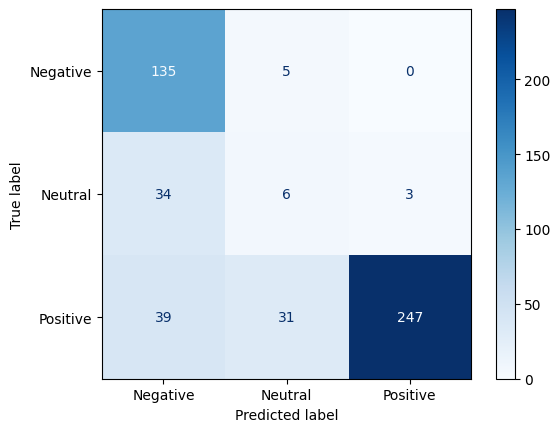

In [18]:
ConfusionMatrixDisplay.from_predictions(zero_shot_base__true_labels, zero_shot_base__pred_labels, cmap='Blues')

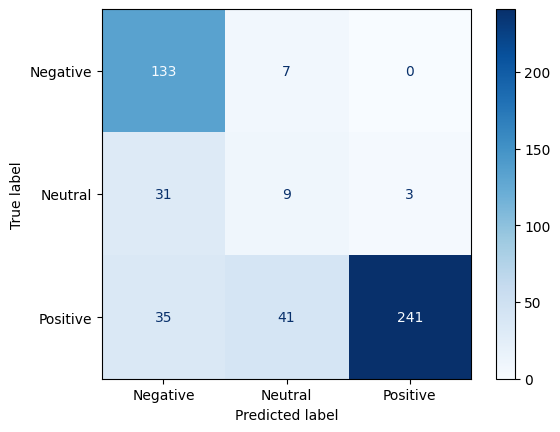

In [19]:
ConfusionMatrixDisplay.from_predictions(few_shot_base__true_labels, few_shot_base__pred_labels, cmap='Blues')

In [20]:
few_shot_temp_07_base__true_labels, few_shot_temp_07_base__pred_labels, few_shot_temp_07_base__y_pred, few_shot_temp_07_base__times = batch_predict(model, tokenizer, label_mapping, y_mapping, few_shot_df_test, 500, 0.7)

<ipython-input-15-fd971248f4d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sample[['pred', 'time']] = df_test_sample.apply(lambda x: predict(x, model, tokenizer, label_mapping, temperature), axis=1, result_type='expand')
<ipython-input-15-fd971248f4d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sample[['pred', 'time']] = df_test_sample.apply(lambda x: predict(x, model, tokenizer, label_mapping, temperature), axis=1, result_type='expand')


In [21]:
print('Few-shot with 0.7 temperature performance')
print(classification_report(few_shot_temp_07_base__true_labels, few_shot_temp_07_base__pred_labels))

Few-shot with 0.7 temperature performance
              precision    recall  f1-score   support

    Negative       0.67      0.96      0.79       140
     Neutral       0.16      0.21      0.18        43
    Positive       0.99      0.76      0.86       317

    accuracy                           0.77       500
   macro avg       0.61      0.64      0.61       500
weighted avg       0.83      0.77      0.78       500



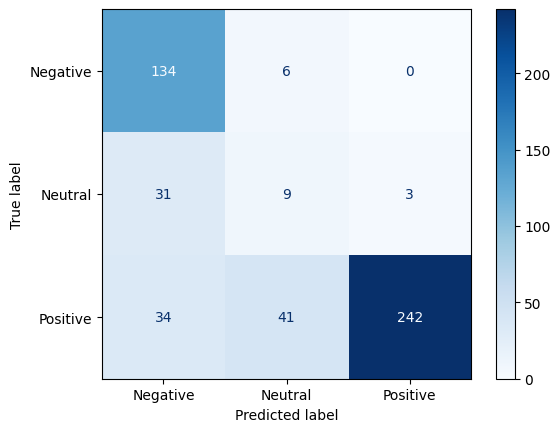

In [22]:
ConfusionMatrixDisplay.from_predictions(few_shot_temp_07_base__true_labels, few_shot_temp_07_base__pred_labels, cmap='Blues')

Among different sets of hyper-parameters, the version with few-shot prompting and tuned temperature to 0.7 gives the best performance, therefore we will use this version for further fine-tuning and evaluation.

{'whiskers': [<matplotlib.lines.Line2D at 0x7a67a0861350>,
 'caps': [<matplotlib.lines.Line2D at 0x7a67a0758650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a67a074ac90>],
 'medians': [<matplotlib.lines.Line2D at 0x7a67a0759910>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a67a075a290>],
 'means': []}

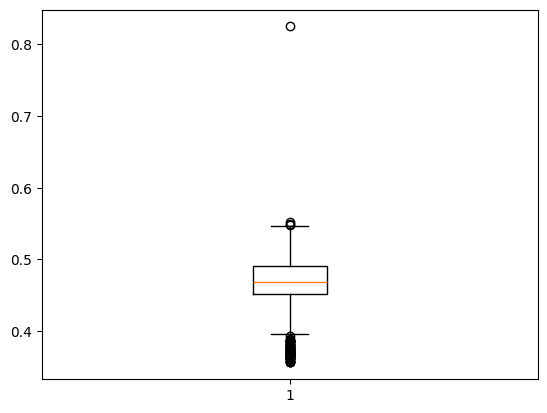

In [23]:
# Check the time to predict samples
plt.boxplot(few_shot_temp_07_base__times)

# Load training data for fine-tuning

In [24]:
train_dataset = load_dataset("Zakia/drugscom_reviews", split="train")
train_dataset = train_dataset.map(generating_labels_func, batched=True, fn_kwargs={'rating_mapping': rating_mapping})
train_dataset = train_dataset.map(label_mapping_func, batched=True, fn_kwargs={'label_mapping': label_mapping})
train_dataset = train_dataset.map(formatting_prompts_func, batched=True, fn_kwargs={'few_shot': True, 'train': True})

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

# Fine-tuning with LORA

In [25]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

In [26]:
def fine_tune(model, tokenizer, train_dataset, num_sample_per_class=1000, lora_rank=16, epochs=1):
    # Prepare data
    shuffled_training_dataset = train_dataset.shuffle()
    train_dataset_label_0 = shuffled_training_dataset.filter(lambda example: example["y"] == 0).select(range(num_sample_per_class))
    train_dataset_label_1 = shuffled_training_dataset.filter(lambda example: example["y"] == 1).select(range(num_sample_per_class))
    train_dataset_label_2 = shuffled_training_dataset.filter(lambda example: example["y"] == 2).select(range(num_sample_per_class))
    train_dataset_sample = concatenate_datasets([train_dataset_label_0, train_dataset_label_1, train_dataset_label_2])

    # Fine-tune
    FastLanguageModel.for_training(model)
    model = FastLanguageModel.get_peft_model(
        model,
        r=lora_rank,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                        "gate_proj", "up_proj", "down_proj",],
        lora_alpha=16,
        lora_dropout=0,
        bias="none",
        use_gradient_checkpointing="unsloth",
        random_state=SEED,
        use_rslora=False,
        loftq_config=None,
    )

    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset_sample,
        dataset_text_field="text",
        formatting_func=None,
        max_seq_length=max_seq_length,
        dataset_num_proc=2,
        packing=False,
        args = TrainingArguments(
            per_device_train_batch_size=2,
            gradient_accumulation_steps=4,
            warmup_steps=5,
            num_train_epochs=epochs,
            learning_rate=2e-4,
            fp16=not is_bfloat16_supported(),
            bf16=is_bfloat16_supported(),
            logging_steps=1,
            optim="adamw_8bit",
            weight_decay=0.01,
            lr_scheduler_type="linear",
            seed=SEED,
            output_dir="outputs",
            report_to="none",
        ),
    )

    trainer_stats = trainer.train()

In [27]:
fine_tune(model, tokenizer, train_dataset, num_sample_per_class=1000, lora_rank=16, epochs=2)

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Unsloth 2025.5.5 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/3000 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 2 | Total steps = 750
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176/7,000,000,000 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.552400
2,2.327800
3,2.506000
4,2.273700
5,1.979400
6,1.854500
7,1.913000
8,1.511300
9,1.417500
10,1.319700


# Test the performance of the fine-tuned model

In [28]:
ft1__true_labels, ft1__pred_labels, ft1__y_pred, ft1__times = batch_predict(model, tokenizer, label_mapping, y_mapping, few_shot_df_test, 500, 0.7)

<ipython-input-15-fd971248f4d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sample[['pred', 'time']] = df_test_sample.apply(lambda x: predict(x, model, tokenizer, label_mapping, temperature), axis=1, result_type='expand')
<ipython-input-15-fd971248f4d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sample[['pred', 'time']] = df_test_sample.apply(lambda x: predict(x, model, tokenizer, label_mapping, temperature), axis=1, result_type='expand')


In [29]:
print(classification_report(ft1__true_labels, ft1__pred_labels))

              precision    recall  f1-score   support

    Negative       0.84      0.87      0.85       140
     Neutral       0.19      0.49      0.27        43
    Positive       0.99      0.75      0.86       317

    accuracy                           0.76       500
   macro avg       0.67      0.70      0.66       500
weighted avg       0.88      0.76      0.80       500



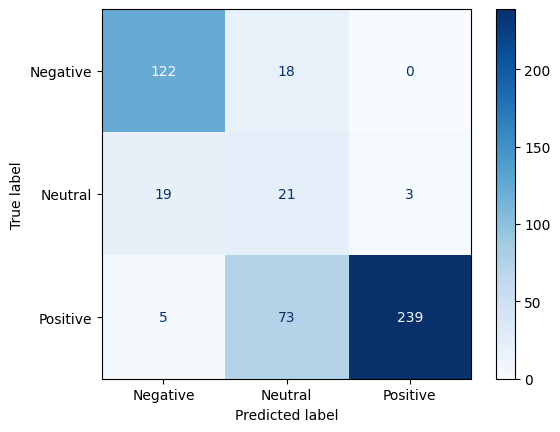

In [30]:
ConfusionMatrixDisplay.from_predictions(ft1__true_labels, ft1__pred_labels, cmap='Blues')

{'whiskers': [<matplotlib.lines.Line2D at 0x7a6790053b90>,
 'caps': [<matplotlib.lines.Line2D at 0x7a6790051610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a6791e53f10>],
 'medians': [<matplotlib.lines.Line2D at 0x7a67900514d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a678ff6c7d0>],
 'means': []}

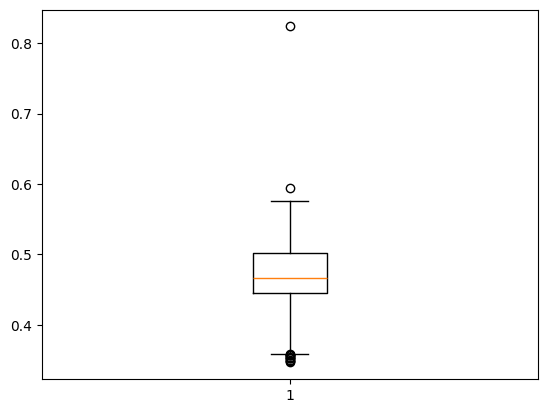

In [31]:
plt.boxplot(ft1__times)

# Save the model

In [32]:
# Save the fine-tuned model in Google Drive
lora_model_path = data_path + "/lora_model"

In [33]:
model.save_pretrained(lora_model_path)
tokenizer.save_pretrained(lora_model_path)

('/content/drive/MyDrive/SIT764/model/lora_model/tokenizer_config.json',
 '/content/drive/MyDrive/SIT764/model/lora_model/special_tokens_map.json',
 '/content/drive/MyDrive/SIT764/model/lora_model/vocab.json',
 '/content/drive/MyDrive/SIT764/model/lora_model/merges.txt',
 '/content/drive/MyDrive/SIT764/model/lora_model/added_tokens.json',
 '/content/drive/MyDrive/SIT764/model/lora_model/tokenizer.json')

# Further fine-tuning

In [34]:
fine_tune(model, tokenizer, train_dataset, num_sample_per_class=500, lora_rank=16, epochs=1)

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1500 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,500 | Num Epochs = 1 | Total steps = 187
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176/7,000,000,000 (0.58% trained)


Step,Training Loss
1,2.495400
2,2.438300
3,2.358200
4,2.268600
5,2.078800
6,1.826700
7,1.668300
8,1.693800
9,1.578500
10,1.377000


In [35]:
ft2__true_labels, ft2__pred_labels, ft2__y_pred, ft2__times = batch_predict(model, tokenizer, label_mapping, y_mapping, few_shot_df_test, 500, 0.7)

<ipython-input-15-fd971248f4d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sample[['pred', 'time']] = df_test_sample.apply(lambda x: predict(x, model, tokenizer, label_mapping, temperature), axis=1, result_type='expand')
<ipython-input-15-fd971248f4d8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sample[['pred', 'time']] = df_test_sample.apply(lambda x: predict(x, model, tokenizer, label_mapping, temperature), axis=1, result_type='expand')


In [36]:
print(classification_report(ft2__true_labels, ft2__pred_labels))

              precision    recall  f1-score   support

    Negative       0.75      0.89      0.81       140
     Neutral       0.13      0.33      0.18        43
    Positive       0.99      0.70      0.82       317

    accuracy                           0.72       500
   macro avg       0.62      0.64      0.61       500
weighted avg       0.85      0.72      0.76       500



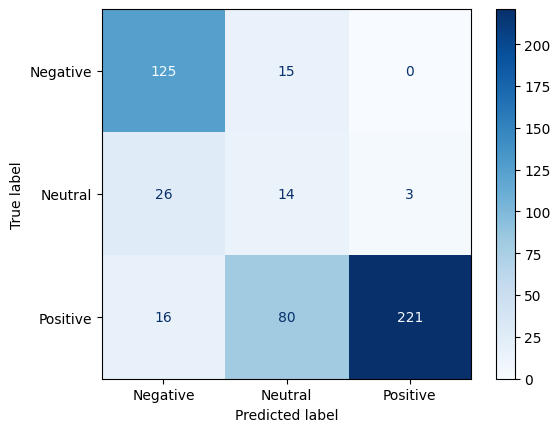

In [37]:
ConfusionMatrixDisplay.from_predictions(ft2__true_labels, ft2__pred_labels, cmap='Blues')

{'whiskers': [<matplotlib.lines.Line2D at 0x7a679360fcd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7a67936f8f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a679360f3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7a67936fa290>],
 'fliers': [<matplotlib.lines.Line2D at 0x7a67936fac10>],
 'means': []}

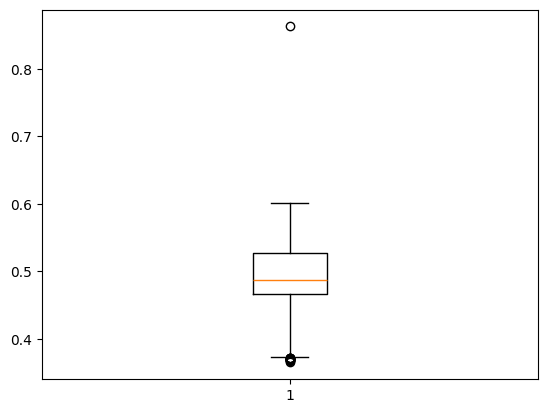

In [38]:
plt.boxplot(ft2__times)

# Performance report

In [39]:
def get_metrics(true, pred):
    return [
        accuracy_score(true, pred),
        precision_score(true, pred, average='macro', zero_division=0),
        recall_score(true, pred, average='macro', zero_division=0),
        f1_score(true, pred, average='macro', zero_division=0)
    ]

In [40]:
zero_shot__metrics = get_metrics(zero_shot_base__true_labels, zero_shot_base__pred_labels)
few_shot__metrics = get_metrics(few_shot_base__true_labels, few_shot_base__pred_labels)
tuned__metrics = get_metrics(few_shot_temp_07_base__true_labels, few_shot_temp_07_base__pred_labels)
ft1__metrics = get_metrics(ft1__true_labels, ft1__pred_labels)
ft2__metrics = get_metrics(ft2__true_labels, ft2__pred_labels)

Plot the final results

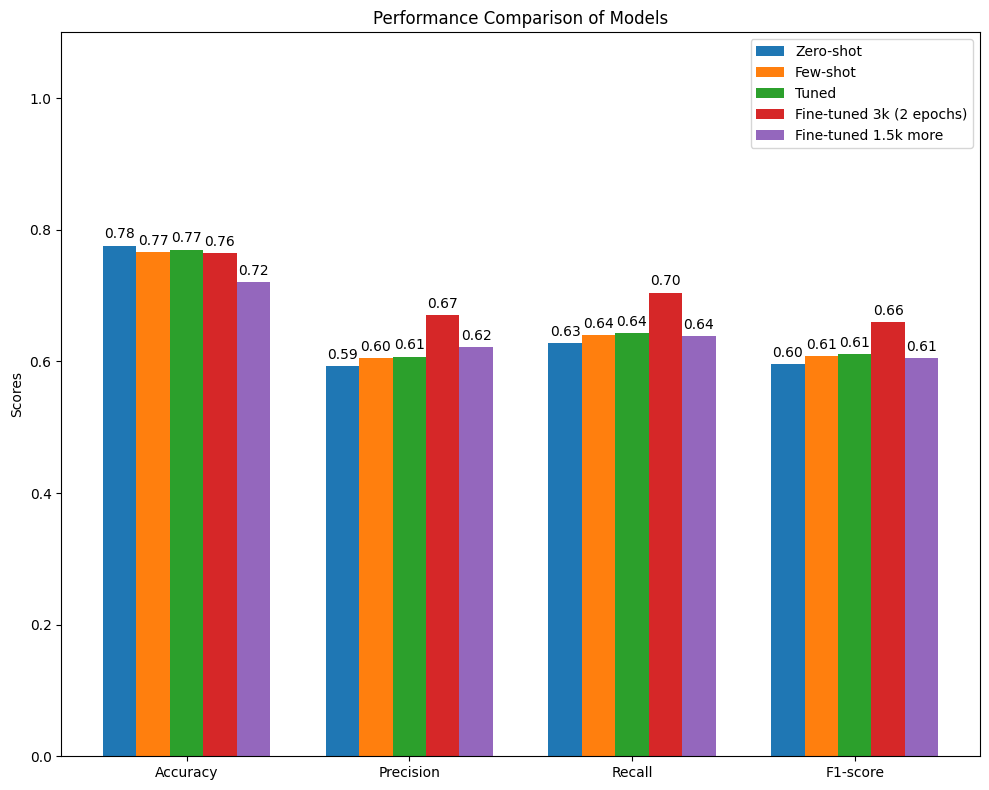

In [41]:
# Data for plotting
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(metric_names))  # label locations
width = 0.15  # width of the bars

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))
bars1 = ax.bar(x - width * 2, zero_shot__metrics, width, label='Zero-shot')
bars2 = ax.bar(x - width, few_shot__metrics, width, label='Few-shot')
bars3 = ax.bar(x, tuned__metrics, width, label='Tuned')
bars4 = ax.bar(x + width, ft1__metrics, width, label='Fine-tuned 3k (2 epochs)')
bars5 = ax.bar(x + width * 2, ft2__metrics, width, label='Fine-tuned 1.5k more')

# Add labels and legend
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.set_ylim(0, 1.1)
ax.legend()

# Display values on bars
for bars in [bars1, bars2, bars3, bars4, bars5]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

The performance of the model after fine-tuning the second time is worse than the first time, so we will use the first fine-tuned version.

# Load the  saved model from Google Drive

We need to restart the runtime to load this. If we run this right after the previous sections, the VRAM on Colab might not be insufficient and the runtime would crash.

In [ ]:
import gc
gc.collect()

0

In [ ]:
lora_model_path = data_path + "/lora_model"

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=lora_model_path,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

==((====))==  Unsloth 2025.5.4: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# UI

In [42]:
import gradio as gr

In [43]:
FastLanguageModel.for_inference(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584, padding_idx=151654)
    (layers): ModuleList(
      (0-1): 2 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=3584, out_features=3584, bias=True)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=3584, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=3584, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=3584, out_features=512, bias=True)
            (lora_dropout): ModuleDict(
              (default): Id

In [44]:
def single_predict(review):
    prompt_template = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

    ### Instruction:
    You are a helpful medical assistant. Your task is to predict the sentiment based on the review of a drug.
    The output will be one of the following sentiments: Positive, Neutral, Negative.
    Make sure that the output only includes one sentiment in the above list, do not add any other word or explanation.

    Examples:
    - Review: "This medication completely cleared up my skin within a week. I couldn't be happier!"
      Sentiment: Positive

    - Review: "I started taking this drug last month. Still waiting to see any major effects."
      Sentiment: Neutral

    - Review: "The side effects were unbearable — constant nausea and dizziness. I had to stop using it."
      Sentiment: Negative

    ### Review: {}

    ### Sentiment:
    """

    messages = [
        {"role": "system", "content": "As a health assistant, you will predict sentiment based on the drug reviews."},
        {"role": "user", "content": prompt_template.format(review)}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        temperature=0.8
    )

    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=64
    )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response

In [45]:
with gr.Blocks() as demo:
    gr.Markdown("Put your review below and then click **Predict** to see the sentiment output.")
    with gr.Row():
        inp = gr.Textbox(placeholder="Type the review", label="Review")
        out = gr.Textbox(label="Output")
    btn = gr.Button("Predict")
    btn.click(fn=single_predict, inputs=inp, outputs=out)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1f11695a5bf54a2662.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
